<a href="https://colab.research.google.com/github/seepala98/EVA4-P2/blob/master/session7_var_autodecoder/notebooks/EVA4P2_S7_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Sat Sep 26 09:00:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 18kB/s 
     |████████████████████████████████| 6.5MB 4.4MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu92


In [ ]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/eva-4/Phase-2/Session-6/cars_red_700_processed.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 70.8 ms, sys: 27.3 ms, total: 98.1 ms
Wall time: 1.46 s


In [ ]:
def prepare_data(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root + '/' + classes[i] + '/'
    data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
    finaldata.extend(data_rec) 
  random.shuffle(finaldata)
  return finaldata

In [ ]:
class_list       = [0]
class_names_dict = {0:'Cars'}
class_names      = ['Cars']

In [ ]:
dataset          = prepare_data('/content/content/car_final',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset)*1)},Test Data length: {int(len(dataset)*0)}')
train_len = int(len(dataset)*1)

Dataset Length:701, Train Data length: 701,Test Data length: 0


In [ ]:
import torchvision.transforms as T
channel_means =(0.503457605838776, 0.425317168235779, 0.419054657220840)
channel_stdevs = (0.248957976698875, 0.255323290824890, 0.257290631532669)
train_transforms=T.Compose([
                     T.Resize((128, 128)),
                     T.ToTensor(),
                     T.Normalize(mean=channel_means, 
                                 std=channel_stdevs),
                     ])

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

class Customdataset(Dataset):
  def __init__(self, data, transform=None):
    self.images, self.labels     = zip(*data)
    self.transform               = transform 

  def __len__(self):
    return len(self.images)  
      
  def __getitem__(self,index):
    if torch.is_tensor(index):
       index = index.tolist()
    
    image = Image.open(self.images[index])  
    if self.transform:
      image = self.transform(image)

    return image, self.labels[index]

In [ ]:
train = Customdataset(dataset[:train_len],train_transforms)

print(f'Train Length {len(train)}') #, Test Length {len(test)}')

Train Length 701


In [ ]:
train_loader  = DataLoader(train, batch_size = 32,shuffle = True, num_workers=2, pin_memory = True)

In [ ]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  #print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

In [ ]:
dataiter = iter(train_loader)

To check if images are coming out correctly as batches, images.shape: torch.Size([32, 3, 128, 128]), labels.shape: torch.Size([32])


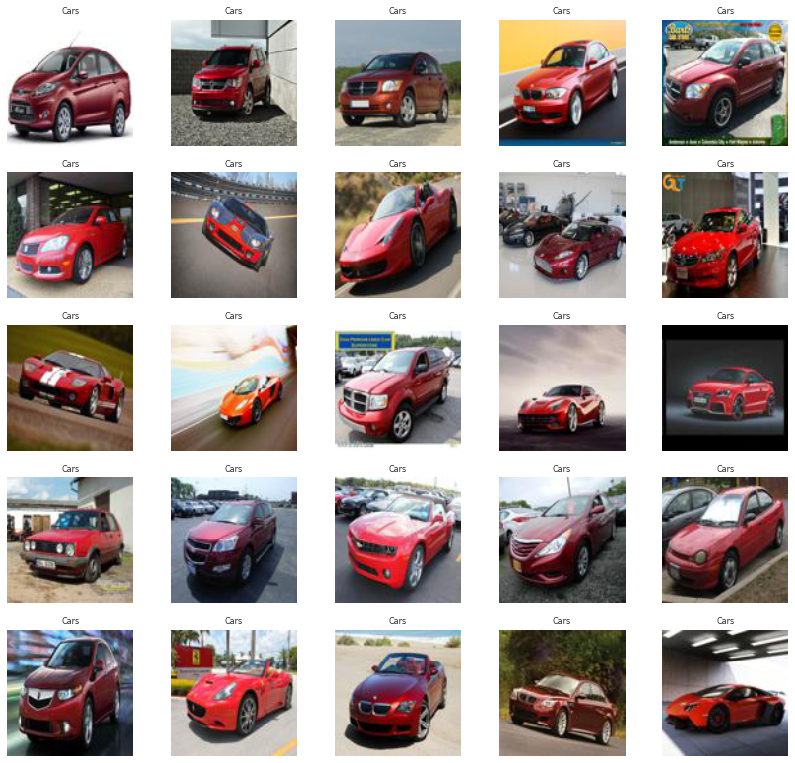

In [ ]:
images, labels = dataiter.next()
print(f'To check if images are coming out correctly as batches, images.shape: {images.shape}, labels.shape: {labels.shape}')
num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    ax.set_title(class_names[labels[idx]][:30], fontdict={'fontsize':8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show() 

In [ ]:
IMAGE_DIM = (128, 128, 3)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, IMAGE_DIM, in_channel=3, out_channel=3, latent_size=100):
        super(VAE, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)  
        self.encode = nn.Sequential(
            # Conv-1 -> 128 -> 64
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # Conv-2 -> 64 -> 32
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # Conv-3 -> 32 -> 16
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Conv-4 -> 16 -> 8
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Conv-5 -> 8 -> 4
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Conv-6 -> 4 -> 2
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), # Adaptive Avg Pool 2x2x100 -> 1x1x100
        )        
        self.fc_encode = nn.Sequential(
            # reshape input, 128 -> 100
            nn.Linear(128, 100),
            #nn.Sigmoid(),
        )
        self.fc_decode = nn.Sequential(
            nn.Linear(latent_size, self.init_dim[0]*self.init_dim[1]*32),
            nn.ReLU(),
        ) # 100 -> 2048
        self.decode = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2048 -> 8x8x32    
            nn.ConvTranspose2d(32, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 8x8x32 -> 16x16x256
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 16x16x256 -> 32x32x128
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 32x32x128 -> 64x64x64                   
            nn.ConvTranspose2d(64, out_channel, 4, stride=2, padding=1, bias=False),
            # 64x64x64 -> 128x128x3
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample   

    def forward(self, x):
        # encoding
        x = self.encode(x)
        x = x.view(x.size(0), -1)
        x = self.fc_encode(x)

        # get `mu` and `log_var`
        mu      = x
        log_var = x
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = z.view(z.size(0), -1)
        x = self.fc_decode(x)
        x = x.view(x.size(0), 32, self.init_dim[0], self.init_dim[1])
        x = self.decode(x)
        return x, mu, log_var  

In [ ]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
model = VAE(IMAGE_DIM, in_channel=IMAGE_DIM[-1],out_channel=IMAGE_DIM[-1]).to(DEVICE)
model.apply(weights_init)
print('Model Defined')

Model Defined


In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 64, 64]          13,824
       BatchNorm2d-2          [-1, 512, 64, 64]           1,024
              ReLU-3          [-1, 512, 64, 64]               0
            Conv2d-4          [-1, 256, 32, 32]       1,179,648
       BatchNorm2d-5          [-1, 256, 32, 32]             512
              ReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         294,912
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 128, 8, 8]         147,456
      BatchNorm2d-11            [-1, 128, 8, 8]             256
             ReLU-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]         147,456
      BatchNorm2d-14            [-1, 12

In [ ]:
!pwd

/content


In [ ]:
import Train_Losses as train_loss 
train_loss = train_loss.Train_loss()

In [ ]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=1e-4)
max_epoch  = 1500
batch_size = 32
img_anim_list, train_loss_all, test_loss_all = [], [], []

In [ ]:
VAE_prev_save = f'/content/gdrive/My Drive/EVA4P2_S7_Training/Model_Weights_D0920/VAE_GPU_499_20200922043600.pt'
model.load_state_dict(torch.load(VAE_prev_save))

<All keys matched successfully>

In [ ]:
for epoch in range(max_epoch):

    train_losses,img_list = train_loss.train_loss_calc(model,DEVICE,train_loader=train_loader,optimizer=opt,
                                                       epoch=epoch, max_epoch= max_epoch, criterion=criterion)                                                       
    #test_losses           = test_loss.test_loss_calc(VAE_Model,DEVICE,test_loader=test_loader,optimizer=VAE_Model_opt,
    #                                                   epoch=epoch, max_epoch= max_epoch,criterion=criterion)   

    if len(img_list) > 0:
        img_anim_list.extend(img_list)                                          

    train_loss_all.append(train_losses)
    #test_loss_all.append(test_losses)
    print(f'Monitoring...Epoch: {epoch+1}/{max_epoch},   Train Loss: {train_losses:.6f}') #, Test Loss: {test_losses:.6f}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-7 Saved - Epoch: 1/1500, Train Loss: 1.036121, batch_idx:20
GPU model saved in epoch 1/1500, batch_idx:20
Monitoring...Epoch: 1/1500,   Train Loss: 1.015399
Monitoring...Epoch: 2/1500,   Train Loss: 0.910625
Monitoring...Epoch: 3/1500,   Train Loss: 0.997346
Monitoring...Epoch: 4/1500,   Train Loss: 0.876475
Monitoring...Epoch: 5/1500,   Train Loss: 0.992128
Monitoring...Epoch: 6/1500,   Train Loss: 0.818799
Monitoring...Epoch: 7/1500,   Train Loss: 0.862769
Monitoring...Epoch: 8/1500,   Train Loss: 0.799416
Monitoring...Epoch: 9/1500,   Train Loss: 0.844406
Monitoring...Epoch: 10/1500,   Train Loss: 0.804204
Monitoring...Epoch: 11/1500,   Train Loss: 0.764441
Monitoring...Epoch: 12/1500,   Train Loss: 0.809154
Monitoring...Epoch: 13/1500,   Train Loss: 0.877487
Monitoring...Epoch: 14/1500,   Train Loss: 0.939102
Monitoring...Epoch: 15/1500,   Train Loss: 0.860978
Monitoring...Epoch: 16/1500,   Train Loss: 0.854303
Monitoring...Epoch: 17/1500,   Train Loss: 0.786554
Monit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-5 Saved - Epoch: 31/1500, Train Loss: 0.892237, batch_idx:20
Monitoring...Epoch: 31/1500,   Train Loss: 0.799065
Monitoring...Epoch: 32/1500,   Train Loss: 0.838063
Monitoring...Epoch: 33/1500,   Train Loss: 0.836100
Monitoring...Epoch: 34/1500,   Train Loss: 0.911254
Monitoring...Epoch: 35/1500,   Train Loss: 0.877703
Monitoring...Epoch: 36/1500,   Train Loss: 0.771312
Monitoring...Epoch: 37/1500,   Train Loss: 0.869544
Monitoring...Epoch: 38/1500,   Train Loss: 0.782674
Monitoring...Epoch: 39/1500,   Train Loss: 0.727680
Monitoring...Epoch: 40/1500,   Train Loss: 0.878291
Monitoring...Epoch: 41/1500,   Train Loss: 0.868751
Monitoring...Epoch: 42/1500,   Train Loss: 0.856132
Monitoring...Epoch: 43/1500,   Train Loss: 0.788791
Monitoring...Epoch: 44/1500,   Train Loss: 0.796572
Monitoring...Epoch: 45/1500,   Train Loss: 0.770656
GPU model saved in epoch 46/1500, batch_idx:20
Monitoring...Epoch: 46/1500,   Train Loss: 0.854022
Monitoring...Epoch: 47/1500,   Train Loss: 0.7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-12 Saved - Epoch: 61/1500, Train Loss: 0.765177, batch_idx:20
Monitoring...Epoch: 61/1500,   Train Loss: 0.863381
Monitoring...Epoch: 62/1500,   Train Loss: 0.794385
Monitoring...Epoch: 63/1500,   Train Loss: 0.864741
Monitoring...Epoch: 64/1500,   Train Loss: 0.762447
Monitoring...Epoch: 65/1500,   Train Loss: 0.792572
Monitoring...Epoch: 66/1500,   Train Loss: 0.855434
Monitoring...Epoch: 67/1500,   Train Loss: 0.766624
Monitoring...Epoch: 68/1500,   Train Loss: 0.880870
Monitoring...Epoch: 69/1500,   Train Loss: 0.841480
Monitoring...Epoch: 70/1500,   Train Loss: 0.817347
Monitoring...Epoch: 71/1500,   Train Loss: 0.773709
Monitoring...Epoch: 72/1500,   Train Loss: 0.748080
Monitoring...Epoch: 73/1500,   Train Loss: 0.756366
Monitoring...Epoch: 74/1500,   Train Loss: 0.781644
Monitoring...Epoch: 75/1500,   Train Loss: 0.839760
Monitoring...Epoch: 76/1500,   Train Loss: 0.775172
Monitoring...Epoch: 77/1500,   Train Loss: 0.732717
Monitoring...Epoch: 78/1500,   Train Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-3 Saved - Epoch: 91/1500, Train Loss: 0.757477, batch_idx:20
GPU model saved in epoch 91/1500, batch_idx:20
Monitoring...Epoch: 91/1500,   Train Loss: 0.763965
Monitoring...Epoch: 92/1500,   Train Loss: 0.771243
Monitoring...Epoch: 93/1500,   Train Loss: 0.765208
Monitoring...Epoch: 94/1500,   Train Loss: 0.793784
Monitoring...Epoch: 95/1500,   Train Loss: 0.730998
Monitoring...Epoch: 96/1500,   Train Loss: 0.828909
Monitoring...Epoch: 97/1500,   Train Loss: 0.800191
Monitoring...Epoch: 98/1500,   Train Loss: 0.816599
Monitoring...Epoch: 99/1500,   Train Loss: 0.761703
Monitoring...Epoch: 100/1500,   Train Loss: 0.762720
Monitoring...Epoch: 101/1500,   Train Loss: 0.782478
Monitoring...Epoch: 102/1500,   Train Loss: 0.808708
Monitoring...Epoch: 103/1500,   Train Loss: 0.839729
Monitoring...Epoch: 104/1500,   Train Loss: 0.742337
Monitoring...Epoch: 105/1500,   Train Loss: 0.893245
Monitoring...Epoch: 106/1500,   Train Loss: 0.672261
Monitoring...Epoch: 107/1500,   Train L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-12 Saved - Epoch: 121/1500, Train Loss: 0.803412, batch_idx:20
Monitoring...Epoch: 121/1500,   Train Loss: 0.776604
Monitoring...Epoch: 122/1500,   Train Loss: 0.746846
Monitoring...Epoch: 123/1500,   Train Loss: 0.723624
Monitoring...Epoch: 124/1500,   Train Loss: 0.794324
Monitoring...Epoch: 125/1500,   Train Loss: 0.733958
Monitoring...Epoch: 126/1500,   Train Loss: 0.780601
Monitoring...Epoch: 127/1500,   Train Loss: 0.756135
Monitoring...Epoch: 128/1500,   Train Loss: 0.844378
Monitoring...Epoch: 129/1500,   Train Loss: 0.823520
Monitoring...Epoch: 130/1500,   Train Loss: 0.920992
Monitoring...Epoch: 131/1500,   Train Loss: 0.896803
Monitoring...Epoch: 132/1500,   Train Loss: 0.705527
Monitoring...Epoch: 133/1500,   Train Loss: 0.771560
Monitoring...Epoch: 134/1500,   Train Loss: 0.710305
Monitoring...Epoch: 135/1500,   Train Loss: 0.868924
GPU model saved in epoch 136/1500, batch_idx:20
Monitoring...Epoch: 136/1500,   Train Loss: 0.729223
Monitoring...Epoch: 137/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-27 Saved - Epoch: 151/1500, Train Loss: 0.815381, batch_idx:20
Monitoring...Epoch: 151/1500,   Train Loss: 0.811371
Monitoring...Epoch: 152/1500,   Train Loss: 0.710467
Monitoring...Epoch: 153/1500,   Train Loss: 0.707486
Monitoring...Epoch: 154/1500,   Train Loss: 0.811115
Monitoring...Epoch: 155/1500,   Train Loss: 0.719172
Monitoring...Epoch: 156/1500,   Train Loss: 0.687662
Monitoring...Epoch: 157/1500,   Train Loss: 0.632227
Monitoring...Epoch: 158/1500,   Train Loss: 0.764802
Monitoring...Epoch: 159/1500,   Train Loss: 0.662353
Monitoring...Epoch: 160/1500,   Train Loss: 0.792060
Monitoring...Epoch: 161/1500,   Train Loss: 0.705068
Monitoring...Epoch: 162/1500,   Train Loss: 0.719855
Monitoring...Epoch: 163/1500,   Train Loss: 0.762532
Monitoring...Epoch: 164/1500,   Train Loss: 0.797762
Monitoring...Epoch: 165/1500,   Train Loss: 0.763342
Monitoring...Epoch: 166/1500,   Train Loss: 0.751452
Monitoring...Epoch: 167/1500,   Train Loss: 0.652453
Monitoring...Epoch: 16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-3 Saved - Epoch: 181/1500, Train Loss: 0.674651, batch_idx:20
GPU model saved in epoch 181/1500, batch_idx:20
Monitoring...Epoch: 181/1500,   Train Loss: 0.770791
Monitoring...Epoch: 182/1500,   Train Loss: 0.707098
Monitoring...Epoch: 183/1500,   Train Loss: 0.759523
Monitoring...Epoch: 184/1500,   Train Loss: 0.744907
Monitoring...Epoch: 185/1500,   Train Loss: 0.754168
Monitoring...Epoch: 186/1500,   Train Loss: 0.680394
Monitoring...Epoch: 187/1500,   Train Loss: 0.770947
Monitoring...Epoch: 188/1500,   Train Loss: 0.755543
Monitoring...Epoch: 189/1500,   Train Loss: 0.672663
Monitoring...Epoch: 190/1500,   Train Loss: 0.558739
Monitoring...Epoch: 191/1500,   Train Loss: 0.702698
Monitoring...Epoch: 192/1500,   Train Loss: 0.740895
Monitoring...Epoch: 193/1500,   Train Loss: 0.714284
Monitoring...Epoch: 194/1500,   Train Loss: 0.838740
Monitoring...Epoch: 195/1500,   Train Loss: 0.840641
Monitoring...Epoch: 196/1500,   Train Loss: 0.702999
Monitoring...Epoch: 197/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-27 Saved - Epoch: 211/1500, Train Loss: 0.791442, batch_idx:20
Monitoring...Epoch: 211/1500,   Train Loss: 0.606592
Monitoring...Epoch: 212/1500,   Train Loss: 0.736563
Monitoring...Epoch: 213/1500,   Train Loss: 0.748123
Monitoring...Epoch: 214/1500,   Train Loss: 0.707895
Monitoring...Epoch: 215/1500,   Train Loss: 0.812831
Monitoring...Epoch: 216/1500,   Train Loss: 0.740539
Monitoring...Epoch: 217/1500,   Train Loss: 0.773156
Monitoring...Epoch: 218/1500,   Train Loss: 0.738031
Monitoring...Epoch: 219/1500,   Train Loss: 0.668056
Monitoring...Epoch: 220/1500,   Train Loss: 0.787694
Monitoring...Epoch: 221/1500,   Train Loss: 0.731889
Monitoring...Epoch: 222/1500,   Train Loss: 0.746190
Monitoring...Epoch: 223/1500,   Train Loss: 0.759383
Monitoring...Epoch: 224/1500,   Train Loss: 0.717731
Monitoring...Epoch: 225/1500,   Train Loss: 0.760273
GPU model saved in epoch 226/1500, batch_idx:20
Monitoring...Epoch: 226/1500,   Train Loss: 0.661645
Monitoring...Epoch: 227/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-2 Saved - Epoch: 241/1500, Train Loss: 0.680443, batch_idx:20
Monitoring...Epoch: 241/1500,   Train Loss: 0.705545
Monitoring...Epoch: 242/1500,   Train Loss: 0.734484
Monitoring...Epoch: 243/1500,   Train Loss: 0.679737
Monitoring...Epoch: 244/1500,   Train Loss: 0.718873
Monitoring...Epoch: 245/1500,   Train Loss: 0.807841
Monitoring...Epoch: 246/1500,   Train Loss: 0.684175
Monitoring...Epoch: 247/1500,   Train Loss: 0.737940
Monitoring...Epoch: 248/1500,   Train Loss: 0.725064
Monitoring...Epoch: 249/1500,   Train Loss: 0.730657
Monitoring...Epoch: 250/1500,   Train Loss: 0.695837
Monitoring...Epoch: 251/1500,   Train Loss: 0.684350
Monitoring...Epoch: 252/1500,   Train Loss: 0.727824
Monitoring...Epoch: 253/1500,   Train Loss: 0.700598
Monitoring...Epoch: 254/1500,   Train Loss: 0.674430
Monitoring...Epoch: 255/1500,   Train Loss: 0.592941
Monitoring...Epoch: 256/1500,   Train Loss: 0.760575
Monitoring...Epoch: 257/1500,   Train Loss: 0.752801
Monitoring...Epoch: 258

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-11 Saved - Epoch: 271/1500, Train Loss: 0.684828, batch_idx:20
GPU model saved in epoch 271/1500, batch_idx:20
Monitoring...Epoch: 271/1500,   Train Loss: 0.735748
Monitoring...Epoch: 272/1500,   Train Loss: 0.666028
Monitoring...Epoch: 273/1500,   Train Loss: 0.763089
Monitoring...Epoch: 274/1500,   Train Loss: 0.721616
Monitoring...Epoch: 275/1500,   Train Loss: 0.653755
Monitoring...Epoch: 276/1500,   Train Loss: 0.765710
Monitoring...Epoch: 277/1500,   Train Loss: 0.702099
Monitoring...Epoch: 278/1500,   Train Loss: 0.693679
Monitoring...Epoch: 279/1500,   Train Loss: 0.706226
Monitoring...Epoch: 280/1500,   Train Loss: 0.801646
Monitoring...Epoch: 281/1500,   Train Loss: 0.727663
Monitoring...Epoch: 282/1500,   Train Loss: 0.696966
Monitoring...Epoch: 283/1500,   Train Loss: 0.696421
Monitoring...Epoch: 284/1500,   Train Loss: 0.631085
Monitoring...Epoch: 285/1500,   Train Loss: 0.606896
Monitoring...Epoch: 286/1500,   Train Loss: 0.884725
Monitoring...Epoch: 287/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-20 Saved - Epoch: 301/1500, Train Loss: 0.747027, batch_idx:20
Monitoring...Epoch: 301/1500,   Train Loss: 0.711433
Monitoring...Epoch: 302/1500,   Train Loss: 0.697709
Monitoring...Epoch: 303/1500,   Train Loss: 0.736864
Monitoring...Epoch: 304/1500,   Train Loss: 0.622761
Monitoring...Epoch: 305/1500,   Train Loss: 0.729493
Monitoring...Epoch: 306/1500,   Train Loss: 0.731554
Monitoring...Epoch: 307/1500,   Train Loss: 0.721104
Monitoring...Epoch: 308/1500,   Train Loss: 0.733733
Monitoring...Epoch: 309/1500,   Train Loss: 0.745151
Monitoring...Epoch: 310/1500,   Train Loss: 0.830174
Monitoring...Epoch: 311/1500,   Train Loss: 0.748629
Monitoring...Epoch: 312/1500,   Train Loss: 0.722325
Monitoring...Epoch: 313/1500,   Train Loss: 0.794398
Monitoring...Epoch: 314/1500,   Train Loss: 0.654655
Monitoring...Epoch: 315/1500,   Train Loss: 0.782844
GPU model saved in epoch 316/1500, batch_idx:20
Monitoring...Epoch: 316/1500,   Train Loss: 0.679047
Monitoring...Epoch: 317/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-13 Saved - Epoch: 331/1500, Train Loss: 0.740564, batch_idx:20
Monitoring...Epoch: 331/1500,   Train Loss: 0.648930
Monitoring...Epoch: 332/1500,   Train Loss: 0.626029
Monitoring...Epoch: 333/1500,   Train Loss: 0.806504
Monitoring...Epoch: 334/1500,   Train Loss: 0.693237
Monitoring...Epoch: 335/1500,   Train Loss: 0.651823
Monitoring...Epoch: 336/1500,   Train Loss: 0.662678
Monitoring...Epoch: 337/1500,   Train Loss: 0.729598
Monitoring...Epoch: 338/1500,   Train Loss: 0.793289
Monitoring...Epoch: 339/1500,   Train Loss: 0.831472
Monitoring...Epoch: 340/1500,   Train Loss: 0.621758
Monitoring...Epoch: 341/1500,   Train Loss: 0.619554
Monitoring...Epoch: 342/1500,   Train Loss: 0.672613
Monitoring...Epoch: 343/1500,   Train Loss: 0.750947
Monitoring...Epoch: 344/1500,   Train Loss: 0.705174
Monitoring...Epoch: 345/1500,   Train Loss: 0.651836
Monitoring...Epoch: 346/1500,   Train Loss: 0.687297
Monitoring...Epoch: 347/1500,   Train Loss: 0.782866
Monitoring...Epoch: 34

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-10 Saved - Epoch: 361/1500, Train Loss: 0.836549, batch_idx:20
GPU model saved in epoch 361/1500, batch_idx:20
Monitoring...Epoch: 361/1500,   Train Loss: 0.707060
Monitoring...Epoch: 362/1500,   Train Loss: 0.710182
Monitoring...Epoch: 363/1500,   Train Loss: 0.599095
Monitoring...Epoch: 364/1500,   Train Loss: 0.783762
Monitoring...Epoch: 365/1500,   Train Loss: 0.677333
Monitoring...Epoch: 366/1500,   Train Loss: 0.681326
Monitoring...Epoch: 367/1500,   Train Loss: 0.694064
Monitoring...Epoch: 368/1500,   Train Loss: 0.579935
Monitoring...Epoch: 369/1500,   Train Loss: 0.750684
Monitoring...Epoch: 370/1500,   Train Loss: 0.810635
Monitoring...Epoch: 371/1500,   Train Loss: 0.733844
Monitoring...Epoch: 372/1500,   Train Loss: 0.635154
Monitoring...Epoch: 373/1500,   Train Loss: 0.688081
Monitoring...Epoch: 374/1500,   Train Loss: 0.723465
Monitoring...Epoch: 375/1500,   Train Loss: 0.722336
Monitoring...Epoch: 376/1500,   Train Loss: 0.683118
Monitoring...Epoch: 377/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-7 Saved - Epoch: 391/1500, Train Loss: 0.705843, batch_idx:20
Monitoring...Epoch: 391/1500,   Train Loss: 0.722823
Monitoring...Epoch: 392/1500,   Train Loss: 0.623944
Monitoring...Epoch: 393/1500,   Train Loss: 0.745522
Monitoring...Epoch: 394/1500,   Train Loss: 0.595590
Monitoring...Epoch: 395/1500,   Train Loss: 0.639552
Monitoring...Epoch: 396/1500,   Train Loss: 0.721372
Monitoring...Epoch: 397/1500,   Train Loss: 0.733949
Monitoring...Epoch: 398/1500,   Train Loss: 0.646795
Monitoring...Epoch: 399/1500,   Train Loss: 0.823049
Monitoring...Epoch: 400/1500,   Train Loss: 0.769998
Monitoring...Epoch: 401/1500,   Train Loss: 0.701957
Monitoring...Epoch: 402/1500,   Train Loss: 0.725152
Monitoring...Epoch: 403/1500,   Train Loss: 0.704805
Monitoring...Epoch: 404/1500,   Train Loss: 0.712003
Monitoring...Epoch: 405/1500,   Train Loss: 0.734372
GPU model saved in epoch 406/1500, batch_idx:20
Monitoring...Epoch: 406/1500,   Train Loss: 0.697059
Monitoring...Epoch: 407/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-16 Saved - Epoch: 421/1500, Train Loss: 0.680306, batch_idx:20
Monitoring...Epoch: 421/1500,   Train Loss: 0.628939
Monitoring...Epoch: 422/1500,   Train Loss: 0.779602
Monitoring...Epoch: 423/1500,   Train Loss: 0.750961
Monitoring...Epoch: 424/1500,   Train Loss: 0.605943
Monitoring...Epoch: 425/1500,   Train Loss: 0.671190
Monitoring...Epoch: 426/1500,   Train Loss: 0.689243
Monitoring...Epoch: 427/1500,   Train Loss: 0.676429
Monitoring...Epoch: 428/1500,   Train Loss: 0.770913
Monitoring...Epoch: 429/1500,   Train Loss: 0.714482
Monitoring...Epoch: 430/1500,   Train Loss: 0.677495
Monitoring...Epoch: 431/1500,   Train Loss: 0.713590
Monitoring...Epoch: 432/1500,   Train Loss: 0.662503
Monitoring...Epoch: 433/1500,   Train Loss: 0.695134
Monitoring...Epoch: 434/1500,   Train Loss: 0.680620
Monitoring...Epoch: 435/1500,   Train Loss: 0.761401
Monitoring...Epoch: 436/1500,   Train Loss: 0.661594
Monitoring...Epoch: 437/1500,   Train Loss: 0.782153
Monitoring...Epoch: 43

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-9 Saved - Epoch: 451/1500, Train Loss: 0.678954, batch_idx:20
GPU model saved in epoch 451/1500, batch_idx:20
Monitoring...Epoch: 451/1500,   Train Loss: 0.810943
Monitoring...Epoch: 452/1500,   Train Loss: 0.830797
Monitoring...Epoch: 453/1500,   Train Loss: 0.638631
Monitoring...Epoch: 454/1500,   Train Loss: 0.668395
Monitoring...Epoch: 455/1500,   Train Loss: 0.659027
Monitoring...Epoch: 456/1500,   Train Loss: 0.622732
Monitoring...Epoch: 457/1500,   Train Loss: 0.676318
Monitoring...Epoch: 458/1500,   Train Loss: 0.795300
Monitoring...Epoch: 459/1500,   Train Loss: 0.740222
Monitoring...Epoch: 460/1500,   Train Loss: 0.756574
Monitoring...Epoch: 461/1500,   Train Loss: 0.682376
Monitoring...Epoch: 462/1500,   Train Loss: 0.666661
Monitoring...Epoch: 463/1500,   Train Loss: 0.692076
Monitoring...Epoch: 464/1500,   Train Loss: 0.696188
Monitoring...Epoch: 465/1500,   Train Loss: 0.602279
Monitoring...Epoch: 466/1500,   Train Loss: 0.675364
Monitoring...Epoch: 467/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-26 Saved - Epoch: 481/1500, Train Loss: 0.762813, batch_idx:20
Monitoring...Epoch: 481/1500,   Train Loss: 0.691783
Monitoring...Epoch: 482/1500,   Train Loss: 0.790252
Monitoring...Epoch: 483/1500,   Train Loss: 0.649854
Monitoring...Epoch: 484/1500,   Train Loss: 0.648054
Monitoring...Epoch: 485/1500,   Train Loss: 0.700757
Monitoring...Epoch: 486/1500,   Train Loss: 0.645387
Monitoring...Epoch: 487/1500,   Train Loss: 0.664138
Monitoring...Epoch: 488/1500,   Train Loss: 0.669340
Monitoring...Epoch: 489/1500,   Train Loss: 0.634208
Monitoring...Epoch: 490/1500,   Train Loss: 0.696242
Monitoring...Epoch: 491/1500,   Train Loss: 0.718903
Monitoring...Epoch: 492/1500,   Train Loss: 0.668779
Monitoring...Epoch: 493/1500,   Train Loss: 0.715164
Monitoring...Epoch: 494/1500,   Train Loss: 0.687580
Monitoring...Epoch: 495/1500,   Train Loss: 0.654252
GPU model saved in epoch 496/1500, batch_idx:20
Monitoring...Epoch: 496/1500,   Train Loss: 0.707905
Monitoring...Epoch: 497/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-19 Saved - Epoch: 511/1500, Train Loss: 0.600918, batch_idx:20
Monitoring...Epoch: 511/1500,   Train Loss: 0.722542
Monitoring...Epoch: 512/1500,   Train Loss: 0.718074
Monitoring...Epoch: 513/1500,   Train Loss: 0.643875
Monitoring...Epoch: 514/1500,   Train Loss: 0.720412
Monitoring...Epoch: 515/1500,   Train Loss: 0.609582
Monitoring...Epoch: 516/1500,   Train Loss: 0.651714
Monitoring...Epoch: 517/1500,   Train Loss: 0.668584
Monitoring...Epoch: 518/1500,   Train Loss: 0.747547
Monitoring...Epoch: 519/1500,   Train Loss: 0.693564
Monitoring...Epoch: 520/1500,   Train Loss: 0.574720
Monitoring...Epoch: 521/1500,   Train Loss: 0.728616
Monitoring...Epoch: 522/1500,   Train Loss: 0.719433
Monitoring...Epoch: 523/1500,   Train Loss: 0.652568
Monitoring...Epoch: 524/1500,   Train Loss: 0.719591
Monitoring...Epoch: 525/1500,   Train Loss: 0.625298
Monitoring...Epoch: 526/1500,   Train Loss: 0.713112
Monitoring...Epoch: 527/1500,   Train Loss: 0.673493
Monitoring...Epoch: 52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-25 Saved - Epoch: 541/1500, Train Loss: 0.712018, batch_idx:20
GPU model saved in epoch 541/1500, batch_idx:20
Monitoring...Epoch: 541/1500,   Train Loss: 0.630708
Monitoring...Epoch: 542/1500,   Train Loss: 0.657869
Monitoring...Epoch: 543/1500,   Train Loss: 0.670652
Monitoring...Epoch: 544/1500,   Train Loss: 0.665115
Monitoring...Epoch: 545/1500,   Train Loss: 0.697578
Monitoring...Epoch: 546/1500,   Train Loss: 0.764493
Monitoring...Epoch: 547/1500,   Train Loss: 0.598613
Monitoring...Epoch: 548/1500,   Train Loss: 0.676444
Monitoring...Epoch: 549/1500,   Train Loss: 0.669175
Monitoring...Epoch: 550/1500,   Train Loss: 0.641594
Monitoring...Epoch: 551/1500,   Train Loss: 0.662528
Monitoring...Epoch: 552/1500,   Train Loss: 0.642126
Monitoring...Epoch: 553/1500,   Train Loss: 0.647228
Monitoring...Epoch: 554/1500,   Train Loss: 0.709355
Monitoring...Epoch: 555/1500,   Train Loss: 0.688258
Monitoring...Epoch: 556/1500,   Train Loss: 0.801536
Monitoring...Epoch: 557/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-26 Saved - Epoch: 571/1500, Train Loss: 0.630678, batch_idx:20
Monitoring...Epoch: 571/1500,   Train Loss: 0.706482
Monitoring...Epoch: 572/1500,   Train Loss: 0.589441
Monitoring...Epoch: 573/1500,   Train Loss: 0.601499
Monitoring...Epoch: 574/1500,   Train Loss: 0.665610
Monitoring...Epoch: 575/1500,   Train Loss: 0.637716
Monitoring...Epoch: 576/1500,   Train Loss: 0.737498
Monitoring...Epoch: 577/1500,   Train Loss: 0.694305
Monitoring...Epoch: 578/1500,   Train Loss: 0.651064
Monitoring...Epoch: 579/1500,   Train Loss: 0.721078
Monitoring...Epoch: 580/1500,   Train Loss: 0.647707
Monitoring...Epoch: 581/1500,   Train Loss: 0.742142
Monitoring...Epoch: 582/1500,   Train Loss: 0.663070
Monitoring...Epoch: 583/1500,   Train Loss: 0.659202
Monitoring...Epoch: 584/1500,   Train Loss: 0.698374
Monitoring...Epoch: 585/1500,   Train Loss: 0.680414
GPU model saved in epoch 586/1500, batch_idx:20
Monitoring...Epoch: 586/1500,   Train Loss: 0.724081
Monitoring...Epoch: 587/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-28 Saved - Epoch: 601/1500, Train Loss: 0.772535, batch_idx:20
Monitoring...Epoch: 601/1500,   Train Loss: 0.622577
Monitoring...Epoch: 602/1500,   Train Loss: 0.635282
Monitoring...Epoch: 603/1500,   Train Loss: 0.673991
Monitoring...Epoch: 604/1500,   Train Loss: 0.619002
Monitoring...Epoch: 605/1500,   Train Loss: 0.727178
Monitoring...Epoch: 606/1500,   Train Loss: 0.812015
Monitoring...Epoch: 607/1500,   Train Loss: 0.741179
Monitoring...Epoch: 608/1500,   Train Loss: 0.774636
Monitoring...Epoch: 609/1500,   Train Loss: 0.710084
Monitoring...Epoch: 610/1500,   Train Loss: 0.770619
Monitoring...Epoch: 611/1500,   Train Loss: 0.690744
Monitoring...Epoch: 612/1500,   Train Loss: 0.700110
Monitoring...Epoch: 613/1500,   Train Loss: 0.718403
Monitoring...Epoch: 614/1500,   Train Loss: 0.731472
Monitoring...Epoch: 615/1500,   Train Loss: 0.551227
Monitoring...Epoch: 616/1500,   Train Loss: 0.670442
Monitoring...Epoch: 617/1500,   Train Loss: 0.666088
Monitoring...Epoch: 61

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-6 Saved - Epoch: 631/1500, Train Loss: 0.682508, batch_idx:20
GPU model saved in epoch 631/1500, batch_idx:20
Monitoring...Epoch: 631/1500,   Train Loss: 0.686558
Monitoring...Epoch: 632/1500,   Train Loss: 0.665770
Monitoring...Epoch: 633/1500,   Train Loss: 0.730197
Monitoring...Epoch: 634/1500,   Train Loss: 0.754476
Monitoring...Epoch: 635/1500,   Train Loss: 0.764401
Monitoring...Epoch: 636/1500,   Train Loss: 0.642443
Monitoring...Epoch: 637/1500,   Train Loss: 0.718168
Monitoring...Epoch: 638/1500,   Train Loss: 0.668348
Monitoring...Epoch: 639/1500,   Train Loss: 0.588587
Monitoring...Epoch: 640/1500,   Train Loss: 0.722625
Monitoring...Epoch: 641/1500,   Train Loss: 0.646489
Monitoring...Epoch: 642/1500,   Train Loss: 0.682239
Monitoring...Epoch: 643/1500,   Train Loss: 0.630371
Monitoring...Epoch: 644/1500,   Train Loss: 0.694260
Monitoring...Epoch: 645/1500,   Train Loss: 0.758294
Monitoring...Epoch: 646/1500,   Train Loss: 0.726332
Monitoring...Epoch: 647/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-28 Saved - Epoch: 661/1500, Train Loss: 0.722564, batch_idx:20
Monitoring...Epoch: 661/1500,   Train Loss: 0.730640
Monitoring...Epoch: 662/1500,   Train Loss: 0.780967
Monitoring...Epoch: 663/1500,   Train Loss: 0.604171
Monitoring...Epoch: 664/1500,   Train Loss: 0.600259
Monitoring...Epoch: 665/1500,   Train Loss: 0.640955
Monitoring...Epoch: 666/1500,   Train Loss: 0.742517
Monitoring...Epoch: 667/1500,   Train Loss: 0.687387
Monitoring...Epoch: 668/1500,   Train Loss: 0.673435
Monitoring...Epoch: 669/1500,   Train Loss: 0.800741
Monitoring...Epoch: 670/1500,   Train Loss: 0.684266
Monitoring...Epoch: 671/1500,   Train Loss: 0.743602
Monitoring...Epoch: 672/1500,   Train Loss: 0.728321
Monitoring...Epoch: 673/1500,   Train Loss: 0.661431
Monitoring...Epoch: 674/1500,   Train Loss: 0.727119
Monitoring...Epoch: 675/1500,   Train Loss: 0.730870
GPU model saved in epoch 676/1500, batch_idx:20
Monitoring...Epoch: 676/1500,   Train Loss: 0.599448
Monitoring...Epoch: 677/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-15 Saved - Epoch: 691/1500, Train Loss: 0.644925, batch_idx:20
Monitoring...Epoch: 691/1500,   Train Loss: 0.760599
Monitoring...Epoch: 692/1500,   Train Loss: 0.693738
Monitoring...Epoch: 693/1500,   Train Loss: 0.704693
Monitoring...Epoch: 694/1500,   Train Loss: 0.616657
Monitoring...Epoch: 695/1500,   Train Loss: 0.720542
Monitoring...Epoch: 696/1500,   Train Loss: 0.666672
Monitoring...Epoch: 697/1500,   Train Loss: 0.662317
Monitoring...Epoch: 698/1500,   Train Loss: 0.710934
Monitoring...Epoch: 699/1500,   Train Loss: 0.738052
Monitoring...Epoch: 700/1500,   Train Loss: 0.765711
Monitoring...Epoch: 701/1500,   Train Loss: 0.732928
Monitoring...Epoch: 702/1500,   Train Loss: 0.712068
Monitoring...Epoch: 703/1500,   Train Loss: 0.704019
Monitoring...Epoch: 704/1500,   Train Loss: 0.668294
Monitoring...Epoch: 705/1500,   Train Loss: 0.669734
Monitoring...Epoch: 706/1500,   Train Loss: 0.664747
Monitoring...Epoch: 707/1500,   Train Loss: 0.677434
Monitoring...Epoch: 70

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-5 Saved - Epoch: 721/1500, Train Loss: 0.720211, batch_idx:20
GPU model saved in epoch 721/1500, batch_idx:20
Monitoring...Epoch: 721/1500,   Train Loss: 0.751037
Monitoring...Epoch: 722/1500,   Train Loss: 0.657562
Monitoring...Epoch: 723/1500,   Train Loss: 0.635419
Monitoring...Epoch: 724/1500,   Train Loss: 0.685022
Monitoring...Epoch: 725/1500,   Train Loss: 0.698597
Monitoring...Epoch: 726/1500,   Train Loss: 0.671021
Monitoring...Epoch: 727/1500,   Train Loss: 0.640822
Monitoring...Epoch: 728/1500,   Train Loss: 0.628606
Monitoring...Epoch: 729/1500,   Train Loss: 0.716191
Monitoring...Epoch: 730/1500,   Train Loss: 0.661308
Monitoring...Epoch: 731/1500,   Train Loss: 0.680499
Monitoring...Epoch: 732/1500,   Train Loss: 0.814764
Monitoring...Epoch: 733/1500,   Train Loss: 0.635131
Monitoring...Epoch: 734/1500,   Train Loss: 0.685960
Monitoring...Epoch: 735/1500,   Train Loss: 0.754106
Monitoring...Epoch: 736/1500,   Train Loss: 0.635816
Monitoring...Epoch: 737/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-9 Saved - Epoch: 751/1500, Train Loss: 0.639744, batch_idx:20
Monitoring...Epoch: 751/1500,   Train Loss: 0.660179
Monitoring...Epoch: 752/1500,   Train Loss: 0.637992
Monitoring...Epoch: 753/1500,   Train Loss: 0.628043
Monitoring...Epoch: 754/1500,   Train Loss: 0.691602
Monitoring...Epoch: 755/1500,   Train Loss: 0.756102
Monitoring...Epoch: 756/1500,   Train Loss: 0.647410
Monitoring...Epoch: 757/1500,   Train Loss: 0.644395
Monitoring...Epoch: 758/1500,   Train Loss: 0.775435
Monitoring...Epoch: 759/1500,   Train Loss: 0.699114
Monitoring...Epoch: 760/1500,   Train Loss: 0.617637
Monitoring...Epoch: 761/1500,   Train Loss: 0.740938
Monitoring...Epoch: 762/1500,   Train Loss: 0.601654
Monitoring...Epoch: 763/1500,   Train Loss: 0.732548
Monitoring...Epoch: 764/1500,   Train Loss: 0.712644
Monitoring...Epoch: 765/1500,   Train Loss: 0.641219
GPU model saved in epoch 766/1500, batch_idx:20
Monitoring...Epoch: 766/1500,   Train Loss: 0.715209
Monitoring...Epoch: 767/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-16 Saved - Epoch: 781/1500, Train Loss: 0.699327, batch_idx:20
Monitoring...Epoch: 781/1500,   Train Loss: 0.621932
Monitoring...Epoch: 782/1500,   Train Loss: 0.704585
Monitoring...Epoch: 783/1500,   Train Loss: 0.624245
Monitoring...Epoch: 784/1500,   Train Loss: 0.724941
Monitoring...Epoch: 785/1500,   Train Loss: 0.698718
Monitoring...Epoch: 786/1500,   Train Loss: 0.667985
Monitoring...Epoch: 787/1500,   Train Loss: 0.628478
Monitoring...Epoch: 788/1500,   Train Loss: 0.585534
Monitoring...Epoch: 789/1500,   Train Loss: 0.614702
Monitoring...Epoch: 790/1500,   Train Loss: 0.622333
Monitoring...Epoch: 791/1500,   Train Loss: 0.633537
Monitoring...Epoch: 792/1500,   Train Loss: 0.734481
Monitoring...Epoch: 793/1500,   Train Loss: 0.735020
Monitoring...Epoch: 794/1500,   Train Loss: 0.722475
Monitoring...Epoch: 795/1500,   Train Loss: 0.706234
Monitoring...Epoch: 796/1500,   Train Loss: 0.719131
Monitoring...Epoch: 797/1500,   Train Loss: 0.626316
Monitoring...Epoch: 79

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-16 Saved - Epoch: 811/1500, Train Loss: 0.694298, batch_idx:20
GPU model saved in epoch 811/1500, batch_idx:20
Monitoring...Epoch: 811/1500,   Train Loss: 0.758750
Monitoring...Epoch: 812/1500,   Train Loss: 0.724647
Monitoring...Epoch: 813/1500,   Train Loss: 0.735014
Monitoring...Epoch: 814/1500,   Train Loss: 0.760149
Monitoring...Epoch: 815/1500,   Train Loss: 0.767195
Monitoring...Epoch: 816/1500,   Train Loss: 0.615487
Monitoring...Epoch: 817/1500,   Train Loss: 0.673338
Monitoring...Epoch: 818/1500,   Train Loss: 0.719607
Monitoring...Epoch: 819/1500,   Train Loss: 0.684605
Monitoring...Epoch: 820/1500,   Train Loss: 0.710443
Monitoring...Epoch: 821/1500,   Train Loss: 0.689803
Monitoring...Epoch: 822/1500,   Train Loss: 0.656558
Monitoring...Epoch: 823/1500,   Train Loss: 0.702383
Monitoring...Epoch: 824/1500,   Train Loss: 0.679773
Monitoring...Epoch: 825/1500,   Train Loss: 0.637212
Monitoring...Epoch: 826/1500,   Train Loss: 0.625829
Monitoring...Epoch: 827/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-23 Saved - Epoch: 841/1500, Train Loss: 0.652751, batch_idx:20
Monitoring...Epoch: 841/1500,   Train Loss: 0.753045
Monitoring...Epoch: 842/1500,   Train Loss: 0.640139
Monitoring...Epoch: 843/1500,   Train Loss: 0.722169
Monitoring...Epoch: 844/1500,   Train Loss: 0.759142
Monitoring...Epoch: 845/1500,   Train Loss: 0.643902
Monitoring...Epoch: 846/1500,   Train Loss: 0.619958
Monitoring...Epoch: 847/1500,   Train Loss: 0.666593
Monitoring...Epoch: 848/1500,   Train Loss: 0.722663
Monitoring...Epoch: 849/1500,   Train Loss: 0.627885
Monitoring...Epoch: 850/1500,   Train Loss: 0.690494
Monitoring...Epoch: 851/1500,   Train Loss: 0.793173
Monitoring...Epoch: 852/1500,   Train Loss: 0.726647
Monitoring...Epoch: 853/1500,   Train Loss: 0.786622
Monitoring...Epoch: 854/1500,   Train Loss: 0.756126
Monitoring...Epoch: 855/1500,   Train Loss: 0.650460
GPU model saved in epoch 856/1500, batch_idx:20
Monitoring...Epoch: 856/1500,   Train Loss: 0.616814
Monitoring...Epoch: 857/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-29 Saved - Epoch: 871/1500, Train Loss: 0.718447, batch_idx:20
Monitoring...Epoch: 871/1500,   Train Loss: 0.844290
Monitoring...Epoch: 872/1500,   Train Loss: 0.655322
Monitoring...Epoch: 873/1500,   Train Loss: 0.745672
Monitoring...Epoch: 874/1500,   Train Loss: 0.723234
Monitoring...Epoch: 875/1500,   Train Loss: 0.620932
Monitoring...Epoch: 876/1500,   Train Loss: 0.567824
Monitoring...Epoch: 877/1500,   Train Loss: 0.691960
Monitoring...Epoch: 878/1500,   Train Loss: 0.686215
Monitoring...Epoch: 879/1500,   Train Loss: 0.727828
Monitoring...Epoch: 880/1500,   Train Loss: 0.651171
Monitoring...Epoch: 881/1500,   Train Loss: 0.730811
Monitoring...Epoch: 882/1500,   Train Loss: 0.748051
Monitoring...Epoch: 883/1500,   Train Loss: 0.693185
Monitoring...Epoch: 884/1500,   Train Loss: 0.651444
Monitoring...Epoch: 885/1500,   Train Loss: 0.590415
Monitoring...Epoch: 886/1500,   Train Loss: 0.718840
Monitoring...Epoch: 887/1500,   Train Loss: 0.730411
Monitoring...Epoch: 88

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-28 Saved - Epoch: 901/1500, Train Loss: 0.635194, batch_idx:20
GPU model saved in epoch 901/1500, batch_idx:20
Monitoring...Epoch: 901/1500,   Train Loss: 0.742480
Monitoring...Epoch: 902/1500,   Train Loss: 0.670145
Monitoring...Epoch: 903/1500,   Train Loss: 0.635027
Monitoring...Epoch: 904/1500,   Train Loss: 0.712067
Monitoring...Epoch: 905/1500,   Train Loss: 0.617742
Monitoring...Epoch: 906/1500,   Train Loss: 0.666038
Monitoring...Epoch: 907/1500,   Train Loss: 0.727950
Monitoring...Epoch: 908/1500,   Train Loss: 0.630451
Monitoring...Epoch: 909/1500,   Train Loss: 0.689258
Monitoring...Epoch: 910/1500,   Train Loss: 0.664029
Monitoring...Epoch: 911/1500,   Train Loss: 0.675470
Monitoring...Epoch: 912/1500,   Train Loss: 0.623591
Monitoring...Epoch: 913/1500,   Train Loss: 0.700594
Monitoring...Epoch: 914/1500,   Train Loss: 0.625560
Monitoring...Epoch: 915/1500,   Train Loss: 0.719518
Monitoring...Epoch: 916/1500,   Train Loss: 0.727550
Monitoring...Epoch: 917/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-1 Saved - Epoch: 931/1500, Train Loss: 0.663926, batch_idx:20
Monitoring...Epoch: 931/1500,   Train Loss: 0.695590
Monitoring...Epoch: 932/1500,   Train Loss: 0.782768
Monitoring...Epoch: 933/1500,   Train Loss: 0.721898
Monitoring...Epoch: 934/1500,   Train Loss: 0.617827
Monitoring...Epoch: 935/1500,   Train Loss: 0.690905
Monitoring...Epoch: 936/1500,   Train Loss: 0.671570
Monitoring...Epoch: 937/1500,   Train Loss: 0.715187
Monitoring...Epoch: 938/1500,   Train Loss: 0.705958
Monitoring...Epoch: 939/1500,   Train Loss: 0.701311
Monitoring...Epoch: 940/1500,   Train Loss: 0.678475
Monitoring...Epoch: 941/1500,   Train Loss: 0.635558
Monitoring...Epoch: 942/1500,   Train Loss: 0.696386
Monitoring...Epoch: 943/1500,   Train Loss: 0.735867
Monitoring...Epoch: 944/1500,   Train Loss: 0.703939
Monitoring...Epoch: 945/1500,   Train Loss: 0.622006
GPU model saved in epoch 946/1500, batch_idx:20
Monitoring...Epoch: 946/1500,   Train Loss: 0.631925
Monitoring...Epoch: 947/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-4 Saved - Epoch: 961/1500, Train Loss: 0.635085, batch_idx:20
Monitoring...Epoch: 961/1500,   Train Loss: 0.613016
Monitoring...Epoch: 962/1500,   Train Loss: 0.700603
Monitoring...Epoch: 963/1500,   Train Loss: 0.647420
Monitoring...Epoch: 964/1500,   Train Loss: 0.667509
Monitoring...Epoch: 965/1500,   Train Loss: 0.664101
Monitoring...Epoch: 966/1500,   Train Loss: 0.599024
Monitoring...Epoch: 967/1500,   Train Loss: 0.653304
Monitoring...Epoch: 968/1500,   Train Loss: 0.726625
Monitoring...Epoch: 969/1500,   Train Loss: 0.697319
Monitoring...Epoch: 970/1500,   Train Loss: 0.762703
Monitoring...Epoch: 971/1500,   Train Loss: 0.620490
Monitoring...Epoch: 972/1500,   Train Loss: 0.659491
Monitoring...Epoch: 973/1500,   Train Loss: 0.754796
Monitoring...Epoch: 974/1500,   Train Loss: 0.734611
Monitoring...Epoch: 975/1500,   Train Loss: 0.745460
Monitoring...Epoch: 976/1500,   Train Loss: 0.773860
Monitoring...Epoch: 977/1500,   Train Loss: 0.772342
Monitoring...Epoch: 978

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-3 Saved - Epoch: 991/1500, Train Loss: 0.736505, batch_idx:20
GPU model saved in epoch 991/1500, batch_idx:20
Monitoring...Epoch: 991/1500,   Train Loss: 0.640519
Monitoring...Epoch: 992/1500,   Train Loss: 0.599618
Monitoring...Epoch: 993/1500,   Train Loss: 0.711089
Monitoring...Epoch: 994/1500,   Train Loss: 0.601754
Monitoring...Epoch: 995/1500,   Train Loss: 0.792547
Monitoring...Epoch: 996/1500,   Train Loss: 0.697884
Monitoring...Epoch: 997/1500,   Train Loss: 0.572717
Monitoring...Epoch: 998/1500,   Train Loss: 0.698533
Monitoring...Epoch: 999/1500,   Train Loss: 0.698535
Monitoring...Epoch: 1000/1500,   Train Loss: 0.746284
Monitoring...Epoch: 1001/1500,   Train Loss: 0.762264
Monitoring...Epoch: 1002/1500,   Train Loss: 0.731436
Monitoring...Epoch: 1003/1500,   Train Loss: 0.685420
Monitoring...Epoch: 1004/1500,   Train Loss: 0.654915
Monitoring...Epoch: 1005/1500,   Train Loss: 0.629262
Monitoring...Epoch: 1006/1500,   Train Loss: 0.791120
Monitoring...Epoch: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-14 Saved - Epoch: 1021/1500, Train Loss: 0.638648, batch_idx:20
Monitoring...Epoch: 1021/1500,   Train Loss: 0.700635
Monitoring...Epoch: 1022/1500,   Train Loss: 0.659451
Monitoring...Epoch: 1023/1500,   Train Loss: 0.708210
Monitoring...Epoch: 1024/1500,   Train Loss: 0.628577
Monitoring...Epoch: 1025/1500,   Train Loss: 0.662184
Monitoring...Epoch: 1026/1500,   Train Loss: 0.582134
Monitoring...Epoch: 1027/1500,   Train Loss: 0.698133
Monitoring...Epoch: 1028/1500,   Train Loss: 0.689307
Monitoring...Epoch: 1029/1500,   Train Loss: 0.716049
Monitoring...Epoch: 1030/1500,   Train Loss: 0.698059
Monitoring...Epoch: 1031/1500,   Train Loss: 0.688658
Monitoring...Epoch: 1032/1500,   Train Loss: 0.657055
Monitoring...Epoch: 1033/1500,   Train Loss: 0.644157
Monitoring...Epoch: 1034/1500,   Train Loss: 0.752030
Monitoring...Epoch: 1035/1500,   Train Loss: 0.625042
GPU model saved in epoch 1036/1500, batch_idx:20
Monitoring...Epoch: 1036/1500,   Train Loss: 0.711059
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-27 Saved - Epoch: 1051/1500, Train Loss: 0.681743, batch_idx:20
Monitoring...Epoch: 1051/1500,   Train Loss: 0.639375
Monitoring...Epoch: 1052/1500,   Train Loss: 0.618021
Monitoring...Epoch: 1053/1500,   Train Loss: 0.617530
Monitoring...Epoch: 1054/1500,   Train Loss: 0.682290
Monitoring...Epoch: 1055/1500,   Train Loss: 0.689900
Monitoring...Epoch: 1056/1500,   Train Loss: 0.608123
Monitoring...Epoch: 1057/1500,   Train Loss: 0.718412
Monitoring...Epoch: 1058/1500,   Train Loss: 0.690196
Monitoring...Epoch: 1059/1500,   Train Loss: 0.665489
Monitoring...Epoch: 1060/1500,   Train Loss: 0.665528
Monitoring...Epoch: 1061/1500,   Train Loss: 0.622924
Monitoring...Epoch: 1062/1500,   Train Loss: 0.712544
Monitoring...Epoch: 1063/1500,   Train Loss: 0.663032
Monitoring...Epoch: 1064/1500,   Train Loss: 0.636412
Monitoring...Epoch: 1065/1500,   Train Loss: 0.718829
Monitoring...Epoch: 1066/1500,   Train Loss: 0.714624
Monitoring...Epoch: 1067/1500,   Train Loss: 0.625650
Moni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-24 Saved - Epoch: 1081/1500, Train Loss: 0.751286, batch_idx:20
GPU model saved in epoch 1081/1500, batch_idx:20
Monitoring...Epoch: 1081/1500,   Train Loss: 0.703613
Monitoring...Epoch: 1082/1500,   Train Loss: 0.608517
Monitoring...Epoch: 1083/1500,   Train Loss: 0.568434
Monitoring...Epoch: 1084/1500,   Train Loss: 0.707357
Monitoring...Epoch: 1085/1500,   Train Loss: 0.669502
Monitoring...Epoch: 1086/1500,   Train Loss: 0.607809
Monitoring...Epoch: 1087/1500,   Train Loss: 0.657347
Monitoring...Epoch: 1088/1500,   Train Loss: 0.565961
Monitoring...Epoch: 1089/1500,   Train Loss: 0.632460
Monitoring...Epoch: 1090/1500,   Train Loss: 0.749852
Monitoring...Epoch: 1091/1500,   Train Loss: 0.784375
Monitoring...Epoch: 1092/1500,   Train Loss: 0.773082
Monitoring...Epoch: 1093/1500,   Train Loss: 0.576660
Monitoring...Epoch: 1094/1500,   Train Loss: 0.658985
Monitoring...Epoch: 1095/1500,   Train Loss: 0.808583
Monitoring...Epoch: 1096/1500,   Train Loss: 0.699686
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-30 Saved - Epoch: 1111/1500, Train Loss: 0.648073, batch_idx:20
Monitoring...Epoch: 1111/1500,   Train Loss: 0.631832
Monitoring...Epoch: 1112/1500,   Train Loss: 0.632661
Monitoring...Epoch: 1113/1500,   Train Loss: 0.740403
Monitoring...Epoch: 1114/1500,   Train Loss: 0.694008
Monitoring...Epoch: 1115/1500,   Train Loss: 0.637249
Monitoring...Epoch: 1116/1500,   Train Loss: 0.703724
Monitoring...Epoch: 1117/1500,   Train Loss: 0.640159
Monitoring...Epoch: 1118/1500,   Train Loss: 0.707680
Monitoring...Epoch: 1119/1500,   Train Loss: 0.668557
Monitoring...Epoch: 1120/1500,   Train Loss: 0.674519
Monitoring...Epoch: 1121/1500,   Train Loss: 0.657775
Monitoring...Epoch: 1122/1500,   Train Loss: 0.746706
Monitoring...Epoch: 1123/1500,   Train Loss: 0.689313
Monitoring...Epoch: 1124/1500,   Train Loss: 0.662566
Monitoring...Epoch: 1125/1500,   Train Loss: 0.765288
GPU model saved in epoch 1126/1500, batch_idx:20
Monitoring...Epoch: 1126/1500,   Train Loss: 0.576942
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-18 Saved - Epoch: 1141/1500, Train Loss: 0.675130, batch_idx:20
Monitoring...Epoch: 1141/1500,   Train Loss: 0.620311
Monitoring...Epoch: 1142/1500,   Train Loss: 0.602801
Monitoring...Epoch: 1143/1500,   Train Loss: 0.704194
Monitoring...Epoch: 1144/1500,   Train Loss: 0.666807
Monitoring...Epoch: 1145/1500,   Train Loss: 0.693217
Monitoring...Epoch: 1146/1500,   Train Loss: 0.746323
Monitoring...Epoch: 1147/1500,   Train Loss: 0.698249
Monitoring...Epoch: 1148/1500,   Train Loss: 0.689222
Monitoring...Epoch: 1149/1500,   Train Loss: 0.636603
Monitoring...Epoch: 1150/1500,   Train Loss: 0.610625
Monitoring...Epoch: 1151/1500,   Train Loss: 0.683383
Monitoring...Epoch: 1152/1500,   Train Loss: 0.642294
Monitoring...Epoch: 1153/1500,   Train Loss: 0.648131
Monitoring...Epoch: 1154/1500,   Train Loss: 0.682308
Monitoring...Epoch: 1155/1500,   Train Loss: 0.720146
Monitoring...Epoch: 1156/1500,   Train Loss: 0.684997
Monitoring...Epoch: 1157/1500,   Train Loss: 0.596653
Moni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-22 Saved - Epoch: 1171/1500, Train Loss: 0.610218, batch_idx:20
GPU model saved in epoch 1171/1500, batch_idx:20
Monitoring...Epoch: 1171/1500,   Train Loss: 0.663427
Monitoring...Epoch: 1172/1500,   Train Loss: 0.710054
Monitoring...Epoch: 1173/1500,   Train Loss: 0.666878
Monitoring...Epoch: 1174/1500,   Train Loss: 0.630610
Monitoring...Epoch: 1175/1500,   Train Loss: 0.744290
Monitoring...Epoch: 1176/1500,   Train Loss: 0.717801
Monitoring...Epoch: 1177/1500,   Train Loss: 0.647130
Monitoring...Epoch: 1178/1500,   Train Loss: 0.661664
Monitoring...Epoch: 1179/1500,   Train Loss: 0.725885
Monitoring...Epoch: 1180/1500,   Train Loss: 0.654476
Monitoring...Epoch: 1181/1500,   Train Loss: 0.811325
Monitoring...Epoch: 1182/1500,   Train Loss: 0.709712
Monitoring...Epoch: 1183/1500,   Train Loss: 0.734259
Monitoring...Epoch: 1184/1500,   Train Loss: 0.653239
Monitoring...Epoch: 1185/1500,   Train Loss: 0.795479
Monitoring...Epoch: 1186/1500,   Train Loss: 0.711962
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-14 Saved - Epoch: 1201/1500, Train Loss: 0.682514, batch_idx:20
Monitoring...Epoch: 1201/1500,   Train Loss: 0.755149
Monitoring...Epoch: 1202/1500,   Train Loss: 0.636996
Monitoring...Epoch: 1203/1500,   Train Loss: 0.649074
Monitoring...Epoch: 1204/1500,   Train Loss: 0.672020
Monitoring...Epoch: 1205/1500,   Train Loss: 0.671808
Monitoring...Epoch: 1206/1500,   Train Loss: 0.720030
Monitoring...Epoch: 1207/1500,   Train Loss: 0.669114
Monitoring...Epoch: 1208/1500,   Train Loss: 0.618657
Monitoring...Epoch: 1209/1500,   Train Loss: 0.693425
Monitoring...Epoch: 1210/1500,   Train Loss: 0.598958
Monitoring...Epoch: 1211/1500,   Train Loss: 0.689002
Monitoring...Epoch: 1212/1500,   Train Loss: 0.717996
Monitoring...Epoch: 1213/1500,   Train Loss: 0.720344
Monitoring...Epoch: 1214/1500,   Train Loss: 0.673649
Monitoring...Epoch: 1215/1500,   Train Loss: 0.736748
GPU model saved in epoch 1216/1500, batch_idx:20
Monitoring...Epoch: 1216/1500,   Train Loss: 0.688848
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-4 Saved - Epoch: 1231/1500, Train Loss: 0.652387, batch_idx:20
Monitoring...Epoch: 1231/1500,   Train Loss: 0.605835
Monitoring...Epoch: 1232/1500,   Train Loss: 0.623042
Monitoring...Epoch: 1233/1500,   Train Loss: 0.766945
Monitoring...Epoch: 1234/1500,   Train Loss: 0.536231
Monitoring...Epoch: 1235/1500,   Train Loss: 0.660433
Monitoring...Epoch: 1236/1500,   Train Loss: 0.743049
Monitoring...Epoch: 1237/1500,   Train Loss: 0.826322
Monitoring...Epoch: 1238/1500,   Train Loss: 0.707782
Monitoring...Epoch: 1239/1500,   Train Loss: 0.675075
Monitoring...Epoch: 1240/1500,   Train Loss: 0.677432
Monitoring...Epoch: 1241/1500,   Train Loss: 0.657117
Monitoring...Epoch: 1242/1500,   Train Loss: 0.744718
Monitoring...Epoch: 1243/1500,   Train Loss: 0.623347
Monitoring...Epoch: 1244/1500,   Train Loss: 0.792132
Monitoring...Epoch: 1245/1500,   Train Loss: 0.669825
Monitoring...Epoch: 1246/1500,   Train Loss: 0.714702
Monitoring...Epoch: 1247/1500,   Train Loss: 0.622336
Monit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-21 Saved - Epoch: 1261/1500, Train Loss: 0.632391, batch_idx:20
GPU model saved in epoch 1261/1500, batch_idx:20
Monitoring...Epoch: 1261/1500,   Train Loss: 0.665241
Monitoring...Epoch: 1262/1500,   Train Loss: 0.646397
Monitoring...Epoch: 1263/1500,   Train Loss: 0.719979
Monitoring...Epoch: 1264/1500,   Train Loss: 0.792418
Monitoring...Epoch: 1265/1500,   Train Loss: 0.648531
Monitoring...Epoch: 1266/1500,   Train Loss: 0.711330
Monitoring...Epoch: 1267/1500,   Train Loss: 0.623271
Monitoring...Epoch: 1268/1500,   Train Loss: 0.731153
Monitoring...Epoch: 1269/1500,   Train Loss: 0.734134
Monitoring...Epoch: 1270/1500,   Train Loss: 0.635743
Monitoring...Epoch: 1271/1500,   Train Loss: 0.673497
Monitoring...Epoch: 1272/1500,   Train Loss: 0.642359
Monitoring...Epoch: 1273/1500,   Train Loss: 0.611746
Monitoring...Epoch: 1274/1500,   Train Loss: 0.699166
Monitoring...Epoch: 1275/1500,   Train Loss: 0.701432
Monitoring...Epoch: 1276/1500,   Train Loss: 0.728397
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-9 Saved - Epoch: 1291/1500, Train Loss: 0.665797, batch_idx:20
Monitoring...Epoch: 1291/1500,   Train Loss: 0.684636
Monitoring...Epoch: 1292/1500,   Train Loss: 0.662780
Monitoring...Epoch: 1293/1500,   Train Loss: 0.706945
Monitoring...Epoch: 1294/1500,   Train Loss: 0.647988
Monitoring...Epoch: 1295/1500,   Train Loss: 0.642695
Monitoring...Epoch: 1296/1500,   Train Loss: 0.693471
Monitoring...Epoch: 1297/1500,   Train Loss: 0.723582
Monitoring...Epoch: 1298/1500,   Train Loss: 0.750323
Monitoring...Epoch: 1299/1500,   Train Loss: 0.606313
Monitoring...Epoch: 1300/1500,   Train Loss: 0.777636
Monitoring...Epoch: 1301/1500,   Train Loss: 0.756101
Monitoring...Epoch: 1302/1500,   Train Loss: 0.627117
Monitoring...Epoch: 1303/1500,   Train Loss: 0.728283
Monitoring...Epoch: 1304/1500,   Train Loss: 0.599850
Monitoring...Epoch: 1305/1500,   Train Loss: 0.685149
GPU model saved in epoch 1306/1500, batch_idx:20
Monitoring...Epoch: 1306/1500,   Train Loss: 0.686576
Monitoring

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-2 Saved - Epoch: 1321/1500, Train Loss: 0.609101, batch_idx:20
Monitoring...Epoch: 1321/1500,   Train Loss: 0.638641
Monitoring...Epoch: 1322/1500,   Train Loss: 0.669275
Monitoring...Epoch: 1323/1500,   Train Loss: 0.649270
Monitoring...Epoch: 1324/1500,   Train Loss: 0.579041
Monitoring...Epoch: 1325/1500,   Train Loss: 0.750330
Monitoring...Epoch: 1326/1500,   Train Loss: 0.608005
Monitoring...Epoch: 1327/1500,   Train Loss: 0.675256
Monitoring...Epoch: 1328/1500,   Train Loss: 0.751866
Monitoring...Epoch: 1329/1500,   Train Loss: 0.673609
Monitoring...Epoch: 1330/1500,   Train Loss: 0.713378
Monitoring...Epoch: 1331/1500,   Train Loss: 0.636980
Monitoring...Epoch: 1332/1500,   Train Loss: 0.701316
Monitoring...Epoch: 1333/1500,   Train Loss: 0.602679
Monitoring...Epoch: 1334/1500,   Train Loss: 0.745350
Monitoring...Epoch: 1335/1500,   Train Loss: 0.717270
Monitoring...Epoch: 1336/1500,   Train Loss: 0.650219
Monitoring...Epoch: 1337/1500,   Train Loss: 0.686097
Monit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-1 Saved - Epoch: 1351/1500, Train Loss: 0.676890, batch_idx:20
GPU model saved in epoch 1351/1500, batch_idx:20
Monitoring...Epoch: 1351/1500,   Train Loss: 0.745396
Monitoring...Epoch: 1352/1500,   Train Loss: 0.652880
Monitoring...Epoch: 1353/1500,   Train Loss: 0.715547
Monitoring...Epoch: 1354/1500,   Train Loss: 0.639804
Monitoring...Epoch: 1355/1500,   Train Loss: 0.627085
Monitoring...Epoch: 1356/1500,   Train Loss: 0.684901
Monitoring...Epoch: 1357/1500,   Train Loss: 0.790632
Monitoring...Epoch: 1358/1500,   Train Loss: 0.642891
Monitoring...Epoch: 1359/1500,   Train Loss: 0.614944
Monitoring...Epoch: 1360/1500,   Train Loss: 0.668861
Monitoring...Epoch: 1361/1500,   Train Loss: 0.673389
Monitoring...Epoch: 1362/1500,   Train Loss: 0.652525
Monitoring...Epoch: 1363/1500,   Train Loss: 0.711458
Monitoring...Epoch: 1364/1500,   Train Loss: 0.595528
Monitoring...Epoch: 1365/1500,   Train Loss: 0.724908
Monitoring...Epoch: 1366/1500,   Train Loss: 0.603970
Monitoring

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-16 Saved - Epoch: 1381/1500, Train Loss: 0.674633, batch_idx:20
Monitoring...Epoch: 1381/1500,   Train Loss: 0.678244
Monitoring...Epoch: 1382/1500,   Train Loss: 0.758656
Monitoring...Epoch: 1383/1500,   Train Loss: 0.696963
Monitoring...Epoch: 1384/1500,   Train Loss: 0.644106
Monitoring...Epoch: 1385/1500,   Train Loss: 0.591313
Monitoring...Epoch: 1386/1500,   Train Loss: 0.697221
Monitoring...Epoch: 1387/1500,   Train Loss: 0.611448
Monitoring...Epoch: 1388/1500,   Train Loss: 0.653827
Monitoring...Epoch: 1389/1500,   Train Loss: 0.639861
Monitoring...Epoch: 1390/1500,   Train Loss: 0.749287
Monitoring...Epoch: 1391/1500,   Train Loss: 0.780207
Monitoring...Epoch: 1392/1500,   Train Loss: 0.659941
Monitoring...Epoch: 1393/1500,   Train Loss: 0.699379
Monitoring...Epoch: 1394/1500,   Train Loss: 0.622412
Monitoring...Epoch: 1395/1500,   Train Loss: 0.644319
GPU model saved in epoch 1396/1500, batch_idx:20
Monitoring...Epoch: 1396/1500,   Train Loss: 0.660493
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-30 Saved - Epoch: 1411/1500, Train Loss: 0.760340, batch_idx:20
Monitoring...Epoch: 1411/1500,   Train Loss: 0.648886
Monitoring...Epoch: 1412/1500,   Train Loss: 0.686336
Monitoring...Epoch: 1413/1500,   Train Loss: 0.680648
Monitoring...Epoch: 1414/1500,   Train Loss: 0.600695
Monitoring...Epoch: 1415/1500,   Train Loss: 0.703750
Monitoring...Epoch: 1416/1500,   Train Loss: 0.730726
Monitoring...Epoch: 1417/1500,   Train Loss: 0.651776
Monitoring...Epoch: 1418/1500,   Train Loss: 0.707158
Monitoring...Epoch: 1419/1500,   Train Loss: 0.685903
Monitoring...Epoch: 1420/1500,   Train Loss: 0.669085
Monitoring...Epoch: 1421/1500,   Train Loss: 0.622918
Monitoring...Epoch: 1422/1500,   Train Loss: 0.693020
Monitoring...Epoch: 1423/1500,   Train Loss: 0.638547
Monitoring...Epoch: 1424/1500,   Train Loss: 0.632456
Monitoring...Epoch: 1425/1500,   Train Loss: 0.619534
Monitoring...Epoch: 1426/1500,   Train Loss: 0.665496
Monitoring...Epoch: 1427/1500,   Train Loss: 0.638356
Moni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-17 Saved - Epoch: 1441/1500, Train Loss: 0.635522, batch_idx:20
GPU model saved in epoch 1441/1500, batch_idx:20
Monitoring...Epoch: 1441/1500,   Train Loss: 0.704932
Monitoring...Epoch: 1442/1500,   Train Loss: 0.710453
Monitoring...Epoch: 1443/1500,   Train Loss: 0.601136
Monitoring...Epoch: 1444/1500,   Train Loss: 0.729809
Monitoring...Epoch: 1445/1500,   Train Loss: 0.661290
Monitoring...Epoch: 1446/1500,   Train Loss: 0.832014
Monitoring...Epoch: 1447/1500,   Train Loss: 0.646574
Monitoring...Epoch: 1448/1500,   Train Loss: 0.630276
Monitoring...Epoch: 1449/1500,   Train Loss: 0.652904
Monitoring...Epoch: 1450/1500,   Train Loss: 0.680022
Monitoring...Epoch: 1451/1500,   Train Loss: 0.679415
Monitoring...Epoch: 1452/1500,   Train Loss: 0.714177
Monitoring...Epoch: 1453/1500,   Train Loss: 0.649619
Monitoring...Epoch: 1454/1500,   Train Loss: 0.698122
Monitoring...Epoch: 1455/1500,   Train Loss: 0.681354
Monitoring...Epoch: 1456/1500,   Train Loss: 0.734540
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-18 Saved - Epoch: 1471/1500, Train Loss: 0.667912, batch_idx:20
Monitoring...Epoch: 1471/1500,   Train Loss: 0.652154
Monitoring...Epoch: 1472/1500,   Train Loss: 0.775268
Monitoring...Epoch: 1473/1500,   Train Loss: 0.701863
Monitoring...Epoch: 1474/1500,   Train Loss: 0.657806
Monitoring...Epoch: 1475/1500,   Train Loss: 0.608024
Monitoring...Epoch: 1476/1500,   Train Loss: 0.703958
Monitoring...Epoch: 1477/1500,   Train Loss: 0.677616
Monitoring...Epoch: 1478/1500,   Train Loss: 0.722898
Monitoring...Epoch: 1479/1500,   Train Loss: 0.649387
Monitoring...Epoch: 1480/1500,   Train Loss: 0.732531
Monitoring...Epoch: 1481/1500,   Train Loss: 0.674052
Monitoring...Epoch: 1482/1500,   Train Loss: 0.745512
Monitoring...Epoch: 1483/1500,   Train Loss: 0.686608
Monitoring...Epoch: 1484/1500,   Train Loss: 0.655120
Monitoring...Epoch: 1485/1500,   Train Loss: 0.693775
GPU model saved in epoch 1486/1500, batch_idx:20
Monitoring...Epoch: 1486/1500,   Train Loss: 0.671408
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-9 Saved - Epoch: 1500/1500, Train Loss: 0.663816, batch_idx:20
GPU model saved in epoch 1500/1500, batch_idx:20
 **** CPU model Saved in epoch:1500/1500, batch_idx:21
Monitoring...Epoch: 1500/1500,   Train Loss: 0.665132


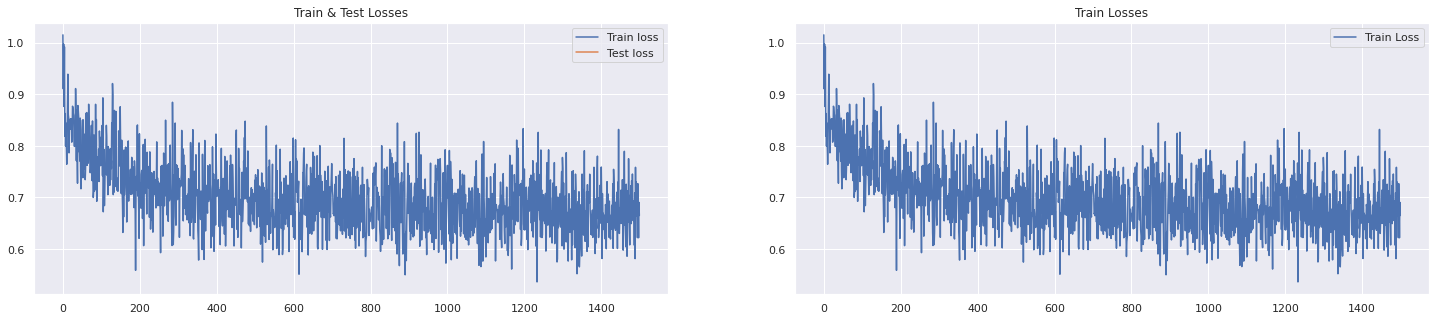

In [ ]:
figure = plt.figure(figsize=(25,5))
labels = ['Loss Plots']

plt.subplot(1,2,1)
plt.title("Train & Test Losses")
plt.plot(train_loss_all,label='Train loss')
plt.plot(test_loss_all,label='Test loss')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.title("Train Losses")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")

# plt.subplot(1,3,3)
# plt.title("Test Losses")
# plt.plot(test_loss_all,label='Test Loss')
# plt.legend(loc="best")

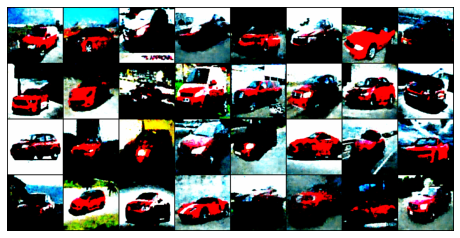

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_anim_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, metadata=dict(artist='Me'), bitrate=1800)
ani.save(f'/content/gdrive/My Drive/eva-4/Phase-2/Session-7/animation_vae_v1.mp4', writer=writer)

In [ ]:
torch.save(model, '/content/gdrive/My Drive/eva-4/Phase-2/Session-7/s7_initial.pt')

In [ ]:
traced_model = torch.jit.trace(model.to('cpu'), torch.randn(512, 3, 3, 3))

In [ ]:
traced_model.save('/content/gdrive/My Drive/eva-4/Phase-2/Session-7/s7_initial.traced.pt')

In [ ]:
decoder_model = torch.load(f'/content/gdrive/My Drive/eva-4/Phase-2/Session-7/model_weights/VAE_GPU_1499_20200925062937.pt')

In [ ]:
def get_sample_image(device, decoder, latent_dims, n_samples=25):
    n_rows = int(np.sqrt(n_samples))
    sample = torch.randn(n_samples, latent_dims)
    sample = sample.to(device)
    sample = decoder(sample)#.cpu()
    sample = torch.cat([torch.cat([sample[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    sample = np.transpose(sample.detach().numpy(),[1,2,0])
    sample = sample.astype(np.float)
    return np.clip(sample,0,1)

In [ ]:
decoder_model = model.to(DEVICE)
decoder_model.eval()
fake_images = get_sample_image(DEVICE, decoder_model, latent_dims=256, n_samples=25)

fig = plt.figure(figsize=(5, 5))
plt.imshow(fake_images)

RuntimeError: ignored

In [ ]:
idx = [0,1]
row, col = IMAGE_DIM[0]*idx[0], IMAGE_DIM[1]*idx[1]
plt.imshow(fake_images[row:row+IMAGE_DIM[0], col:col+IMAGE_DIM[1], :])

In [ ]:
a, b = torch.randn(LATENT_DIMS), torch.randn(LATENT_DIMS)
z = torch.tensor([np.linspace(a[i], b[i], num=10) for i in range(LATENT_DIMS)], dtype=torch.float32).to(device)
z = torch.transpose(z, 0, 1)
z.shape

In [ ]:
imgs = decoder_model(z).cpu()
imgs = torch.cat([imgs[i] for i in range(10)], dim=-1)
imgs = np.transpose(imgs.detach().numpy(),[1,2,0])
imgs.shape
Out[37]:


In [ ]:
fig = plt.figure(figsize=(20, 3))
plt.imshow(imgs)

NameError: ignored

<Figure size 1440x216 with 0 Axes>

In [ ]:
VAE_prev_save = f'/content/gdrive/My Drive/eva-4/Phase-2/Session-7/model_weights/VAE_GPU_1499_20200925062937.pt'
model.load_state_dict(torch.load(VAE_prev_save))

<All keys matched successfully>

In [ ]:
def norm_ip(img, min, max):
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)

def norm_tensor(t):
    norm_ip(t, float(t.min()), float(t.max()))

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
with torch.no_grad():
    fake = model(torch.randn(1, 3, 1, 1).to(device).detach())
fakei = fake[0].cpu()
norm_tensor(fakei)

In [ ]:
def get_sample_image(G, n_noise=100):
    G.eval()
    z = torch.randn(1, n_noise).to(DEVICE)
    print(z.shape)
    y_hat = G(z).view(1, 3, 96, 96).permute(0, 2, 3, 1)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result
